In [1]:
import torch
from torch import nn
from circuits import Circuit,Kinds,Props
from learn import Trainer
from models import Solver
from models import State
from data import Preprocess


In [2]:
# Get cpu or gpu device for training.
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device")

# torch.autograd.set_detect_anomaly(True)
torch.set_printoptions(precision=3, linewidth=200)

Using cpu device


# Generate Input Data for a Simple Circuit
Circuit is an independent voltage source and a resistor.

Circuit with 2 nodes and 2 elements
[0, 1]
[(IVS, 1, 0), (R, 1, 0)]
[(1, {}), (0, {})]
[(1, 0, 1, {'kind': <Kinds.IVS: 0>, 'i': None, 'v': None, 'attr': 1}), (1, 0, 0, {'kind': <Kinds.R: 2>, 'i': 0.5, 'v': None, 'attr': None})]


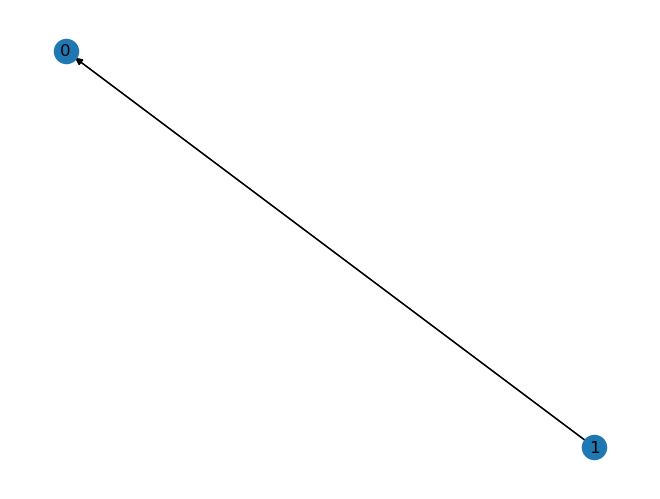

In [3]:
vr = Circuit()
vr.ring(Kinds.IVS,Kinds.R,1)
vr.elements[0].attr = 1
vr.elements[-1].i = 0.5

print(vr)
print(vr.nodes)
print(vr.elements)
vr.draw()
print(vr.nx_graph().nodes().data())
print(vr.nx_graph().edges(data=True,keys=True))

# Create Solver

In [4]:
Kinds.IVS

<Kinds.IVS: 0>

In [5]:
vr.extract_elements()

{'kinds': {<Kinds.IVS: 0>: [True, False],
  <Kinds.ICS: 1>: [False, False],
  <Kinds.R: 2>: [False, True]},
 'properties': {<Props.I: 0>: [None, 0.5],
  <Props.V: 1>: [None, None],
  <Props.Pot: 2>: [None, None]},
 'attributes': {<Kinds.IVS: 0>: [1, None],
  <Kinds.ICS: 1>: [None, None],
  <Kinds.R: 2>: [None, None]}}

In [6]:
input = Preprocess(vr)

c:\Users\terry\OneDrive\Documents\GitHub\side_circuit\ml\circuits.py:104: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  M_scipy = nx.incidence_matrix(G=self.nx_graph(),oriented=True)


In [7]:
input.truth

[0.5363234187044715,
 0.5,
 1,
 0.7892977581784786,
 0.2550787422248001,
 0.1026830806343092]

In [8]:
input.truth_mask

[False, True, True, False, False, False]

In [9]:
input.prop_list(Props.V,False,False)

[None, None]

In [10]:
input.mask_of_prop(Props.Pot,False)

[False, False]

In [11]:
input.mask_of_prop(Props.Pot,True)

[False, False]

In [12]:
input.attr_list(Kinds.IVS)

[1, 0.6186127868195049]

In [13]:
input.attr_list(Kinds.ICS)

[0.01968948453584629, 0.355016712939058]

In [14]:
input.attr_list(Kinds.R)

[0.7948255592780304, 0.46628858758249925]

In [15]:
import time

model = Solver(input=input, state=State.Solve)
start_time = time.time()
X = model()
end_time = time.time()
X

tensor([[-10.604],
        [ 10.604],
        [  1.000],
        [  1.000],
        [ -1.000]], grad_fn=<LinalgSolveExBackward0>)

In [16]:
model.attr

Parameter containing:
tensor([1.000, 0.094], requires_grad=True)

In [17]:
model.all_knowns_mask

tensor([ True, False])

In [18]:
model.attr[model.all_knowns_mask]

tensor([1.], grad_fn=<IndexBackward0>)

In [19]:
model.init_known_attr_mask()

tensor([ True, False])

In [20]:
model.init_attr()

tensor([1.000, 0.667])

In [21]:
print(f'execution time = {(end_time - start_time)*1000} ms')

execution time = 0.99945068359375 ms


# Learn attributes

In [22]:
num_epochs = 1
prev_loss = 0.1

model = Solver(input=input, state=State.Solve)
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.1)
trainer = Trainer(model,optimizer,nn.MSELoss())
loss, _ = trainer.train()
print(f'init params: {model.attr}')
print(f'init loss: {loss.item()}')

epoch = 0

while(epoch < num_epochs):
    loss, _ = trainer.train()
    if(loss < 1e-10):
            break
    epoch += 1
    loss_change = abs(loss - prev_loss) / prev_loss
    prev_loss = loss

print(f'Done! at {epoch} passes, {loss.item()} loss')
print(f'solution = {model()}')
print(f"attributes = {model.attr}")

init params: Parameter containing:
tensor([1.000, 0.449], requires_grad=True)
init loss: 2.805734634399414
Done! at 1 passes, 1.4952397346496582 loss
solution = tensor([[-1.852],
        [ 1.852],
        [ 1.000],
        [ 1.000],
        [-1.000]], grad_fn=<LinalgSolveExBackward0>)
attributes = Parameter containing:
tensor([1.000, 0.540], requires_grad=True)
